In [5]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [7]:
# Model
import impl.layer as l
from impl.loss import *

class LSTM:
    
    def __init__(self, D, H, L, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        
        # Model parameters wights and biases
        Z = H + D
        m = dict(
            Wf=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wi=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wc=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wo=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bf=np.zeros((1, H)),
            bi=np.zeros((1, H)),
            bc=np.zeros((1, H)),
            bo=np.zeros((1, H)),
            by=np.zeros((1, D)))

        self.model = []
        for _ in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return (np.zeros((1, self.H)), np.zeros((1, self.H)))

    def forward(self, X, h, m):
        Wf, Wi, Wc, Wo, Wy = m['Wf'], m['Wi'], m['Wc'], m['Wo'], m['Wy']
        bf, bi, bc, bo, by = m['bf'], m['bi'], m['bc'], m['bo'], m['by']

        h_in, c_in = h
        X_in = X.copy()

        X = np.column_stack((h_in, X_in))

        hf, hf_cache = l.fc_forward(X, Wf, bf)
        hf, hf_sigm_cache = l.sigmoid_forward(hf)

        hi, hi_cache = l.fc_forward(X, Wi, bi)
        hi, hi_sigm_cache = l.sigmoid_forward(hi)

        hc, hc_cache = l.fc_forward(X, Wc, bc)
        hc, hc_tanh_cache = l.tanh_forward(hc)

        ho, ho_cache = l.fc_forward(X, Wo, bo)
        ho, ho_sigm_cache = l.sigmoid_forward(ho)

        c = (hf * c_in) + (hi * hc)
        c, c_tanh_cache = l.tanh_forward(c)

        h = ho * c
        
        h_ = (h, c)
        y, y_cache = l.fc_forward(h, Wy, by)
        
        cache = (c_in, hf, hf_cache, hf_sigm_cache, hi, hi_cache, hi_sigm_cache, hc, hc_cache, hc_tanh_cache, ho, ho_cache, ho_sigm_cache, c, c_tanh_cache, y_cache)
        
        return y, h_, cache

    def backward(self, dy, dh, cache):
        c_in, hf, hf_cache, hf_sigm_cache, hi, hi_cache, hi_sigm_cache, hc, hc_cache, hc_tanh_cache, ho, ho_cache, ho_sigm_cache, c, c_tanh_cache, y_cache = cache

        dh_out, dc_out = dh

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dc = ho * dh
        dc = l.tanh_backward(dc, c_tanh_cache)
        dc += dc_out
        dc_in = hf * dc

        dho = c * dh
        dho = l.sigmoid_backward(dho, ho_sigm_cache)
        dXo, dWo, dbo = l.fc_backward(dho, ho_cache)

        dhc = hi * dc
        dhc = l.tanh_backward(dhc, hc_tanh_cache)
        dXc, dWc, dbc = l.fc_backward(dhc, hc_cache)

        dhi = hc * dc
        dhi = l.sigmoid_backward(dhi, hi_sigm_cache)
        dXi, dWi, dbi = l.fc_backward(dhi, hi_cache)

        dhf = c_in * dc
        dhf = l.sigmoid_backward(dhf, hf_sigm_cache)
        dXf, dWf, dbf = l.fc_backward(dhf, hf_cache)

        dX = dXo + dXc + dXi + dXf
        dh_in = dX[:, :self.H]
        dX_in = dX[:, self.H:]
        
        dh = (dh_in, dc_in)
        dX = dX_in

        grad = dict(Wf=dWf, Wi=dWi, Wc=dWc, Wo=dWo, Wy=dWy, bf=dbf, bi=dbi, bc=dbc, bo=dbo, by=dby)

        return dX, dh, grad
            
    def train_forward(self, X_train, h_):
        ys, caches = [], []
        # h_init = h.copy()
        h, c = h_
        h_init = (h.copy(), c.copy())
        h = []
        for _ in range(self.L):
            h.append(h_init)
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += cross_entropy(y_pred, y)
            dy = dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append((np.zeros((1, self.H)), np.zeros((1, self.H))))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                dy = dX.copy()
            dXs.append(dX)
                
        return dXs, grads
    
    def test(self, X_seed, h_, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        # h_init = h.copy()
        h, c = h_
        h_init = (h.copy(), c.copy())
        h = []
        for _ in range(self.L):
            h.append(h_init)

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [9]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    # for i in range(0, X.shape[0], minibatch_size):
    for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L):
        M.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        R.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    # Epochs
    for iter in range(1, n_iter + 1):
        # Minibatches
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            # Updating the model parameters
            for layer in range(nn.L):
                for key in grads[layer].keys(): #key, value: items, dict={}
                    M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                    R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                    m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                    nn.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)
                
        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, size=200) # time_step=mb_size
            print(sample)
    
    return nn

Iter-1 loss: 330.9961
 snnhi ulstnnn,eoe eoaioteppaosahrasapNks hs fvoaei mf omkisAr oHa edfvist5shivkasncrA,rciro hnitgrJiaooaneisnrievnrai tx h not7yaednthhptekt ysesstta  eIoraccea ae e aidei ieiaar pHhitt iessnan ne tia
Iter-2 loss: 331.6618
  nnegfn r2dnhian suooi oxsueo 1abtees rra 2g ed-uhnei   a sdathhrhlaal en e,mte6ryereagtydde xtartdaaidaveiiua-  snx nty leDylnsum rylgre-yeya 3 aatItnvghtr2vet tsaokNsy nsxpfnaluby1nntospnpyont hyius
Iter-3 loss: 316.8404
 gys n 5J1n  trd lna; aet pan es ,eiorinutIreahxd ylxre maitaubn's 9oc 'bt ibn1ts'd iye ahttIyusihoproht onaaD3t hbnst ea aWsl hiisrs y eop9rht0rkd aai t2ie iius  hdoxtrpnis iyue9wrarlaohmftrm rs Joi o
Iter-4 loss: 261.1497
 natd , uisy fawan torinaa Jte lloJ ,tit  wphiey is ng erger. yd Uir Was henst sans oan rbte Giry Wth nhe an 8ind 9be eea hd Jthe a nreiy kof emiiteemet bond Ateeate pepnret irt Ieare G"he coin in brce
Iter-5 loss: 227.8087
 on Costed Jirhy Jang, Injs uganer.0 Jaf chuonas can bipag ankest in tin, Wod 1Mag

Iter-38 loss: 108.1997
 resiatiof nerudered a period of state in the Japan has ended forlclarce frorcle Grentil an it emento 1senked first hinet 17esirates of vivinly, poxpllanoend Shon-3% of Japan has ofluryod. The hihes in
Iter-39 loss: 102.8320
 in the Glor the world's fou tpyseperiod of and Index, ranked sixth in the G20te nameriesty-rgest revised sourth-largest eclored fiss ji mienclargest merer parted of Empire of felodgtovifit onclacine s
Iter-40 loss: 104.6996
 country has in 19411mmpirinlin-lorlesive of Japan waing momrtiring it miving Hlahe. The fourthe and in the Global Peace Indeked freato high of mined infed upenled of Japan was proclaimes. Japan is off
Iter-41 loss: 104.4470
 the eperter Peand an edho nish a straing it lae ded the world's pourth-largest in the East China and War, with Em3 viit onced Sher, and piriong militaris. fp breaterigest fourmontaply Ic Jap n entered
Iter-42 loss: 101.0474
 ralled the Parearesined Seand in the Paise pirieled Runs cinthimanto the cou

Iter-75 loss: 51.2791
 Asia. Japan is ranked first in the Nipapetical was hans, myorCh-largest effimed incread of largest imitreaty Areaten mention of 1945 follong in the nultion, island Sino-maens in the First Sino-Japanes
Iter-76 loss: 53.6733
 expand conarged of in 1946, which came to an end in 1945 follifontry with the world, and rankeled budod. Japan is a developed country with a high standard largest military China, follifyd Sincate mili
Iter-77 loss: 51.9675
 roughol country city righest-rase peorled Asian cominitary shetrtar's rof Japan was hans in the name of the UN, the G7, the G8, and pecaimed lanounal sinans prowes Eipflitariwy 7the tar dakopulapy win
Iter-78 loss: 50.0046
 the UN, the G7, the G8, and the G20 and is War, mE intion rese Gollonging populanaly world, as the world, of the UN, the G7, the G8, and the world's fourth-largest eriod in thed elof fe Jargoxatios0 h
Iter-79 loss: 49.8962
 ip the Rising Sun". Japan is a stratovolagera asored Japan is a developed country

Iter-112 loss: 35.5655
 6am artition in 1947 from oto. into 47 prefectures in eight regions. The population people world's fourth-largest exporter and fountry in Asia to host both the Summer and pare of the G2lmbof increasin
Iter-113 loss: 35.5162
 ruled by surcally Shikatitsarest Index whos porst imlion in 1941kt renend arl as in the Japan was ruled in the Pared in 1945 following the atomic bombings in 1947th Chstares, it maintains a modent of 
Iter-114 loss: 34.8630
 power paritan Development economy by purchasing power parity. It is an the name of the UN, the G7, the G8, and the G7, to the Eas restored as heat on War and Wod Tong in 1868 and the Emperor and an el
Iter-115 loss: 34.7988
 from the 1stit ittion erof biped in of Japan, the East China Sea, China, Korea and Russia, stretching from the Sea of Okhotsk it nirong in the ere a ures from other ring and Hyipucagh and the wof the 
Iter-116 loss: 34.1493
 fourth-largest importer. Although Japan has officially ruse Empeicor orten "

Iter-149 loss: 28.8977
 Nipen of Nichit leaigelitarihes largest mrea :iet wihe fourth-largest importer. Although Japan has officially renounced its War, ith ya GP vives tor cons a loUlan dident million enjoys the highest lif
Iter-150 loss: 28.3339
 mention of the UN, to an is a modh-stares, is the highest-ranked Asian country in the Global Competitiveness Report 2015–2016 and is the highest-ranked Asian country in the Global Peace Index. Japan w
Iter-151 loss: 28.4525
 nountry in East Asia. Located in the Pacific Ocean, it lies to the east of the Sea of Okhotsk in the north to the East China Sea and Taiwan in the south. The kanji that make up 98.5% of Japan's total 
Iter-152 loss: 28.8917
 the UN, the G7, the Risa, and is divided into 47 prefectures in the name of the Sea of Okhotsk in the north to the East China Sea and Taiwan in the south. The kanji that make up Japan's name mean "sun
Iter-153 loss: 28.5246
 the Russo-Japanes f om ised aigo to dong an an endl In 19tE and early 20th c

Iter-186 loss: 23.6983
 of isolation in 1947, Japan has maintained a unitary constitutional monarchy with an Emperor an heandien in the number of Nobel laureates of any country in Asia. Japan is ranked first in the Country B
Iter-187 loss: 24.7331
 coninern whih largest metropld's largest urban agglomerared into 47 prefectures in eight regions. The raness 2ine a membe tal dealy country in Asia. Japan is ranked first in the cand and in 1945 follo
Iter-188 loss: 28.0277
 isorlanomy stratovolcanic archipelaloeation area with over 35 million residentil 1868, Japan was inh tar. minly in the world, and ranked first in thes st mrive and ranked first in the number in disidi
Iter-189 loss: 27.8226
 country has has mainly Imperial dithe OmCpepirer and mainly ar as the wurld, the third-largest economy wont on onss minlarl aplong prefecturea is the Cant mestiturd-st wiit onombllaed lowed Japan to e
Iter-190 loss: 33.1460
 Asia. Japan is ranked first in the Country Brand Index, ranked sixth in the 

Iter-223 loss: 22.8591
 and peacekeeping roles. Japan is a developed country with a high standard of living and Human Development Index whose population enjoys the highest life expectancy, the third lowest infant mortality i
Iter-224 loss: 20.7075
 ranked hest Eumhint WD, population. Approximately 9.1 million people live in the core city of Tokyo, the third lowest infant mortality in the worll, Somer of the UN, the G7, the G8, and the G20 and is
Iter-225 loss: 21.7398
 whose wientel Un esess Rich gittes fleet pressured Japan to expand its eldPd in Awesicre Astoulal rastomicit. of Hiron-. The population of 126 million is elopal mopmrestored as head-largest economy by
Iter-226 loss: 20.6121
 the world's fourth-largest exporter and fourth-largest importer. Although Japan has officially renounced its right to declare war allion in the early 17th century, which was ended in 1853 when a Unied
Iter-227 loss: 20.6571
 Sea, China, Korea and Nagasaki. Since adallonsine War an ectofll as a nmolsa

Iter-260 loss: 16.5047
 power parital denounced its right to declare war, it maintains a modern military wintary CE. Influence from other regions, mainly Imperial Demeomlo-esio. Japan has sixth empiriall deades of idys inhar
Iter-261 loss: 16.7352
 the Country Brand Index, ranked sixth in the Global Competitiveness Report 2015–2016 and is the highest-ranked Asian country in the Global Peace Index. Japan was the first country int mocbated a unita
Iter-262 loss: 17.1823
 lowe centuries, the world's thirnh fore the the the world's fourth-largest exporter followed before the Meiji Emperor was restored as head of state in 1868 and the G20 and is considered a gred' ryt. T
Iter-263 loss: 41.7735
 to the easturtivantion of Japan's land area. The period of isolation in om the Sea of Japan, the East the third lowest infant mortalityy in the a uloJiss. Japan to open to the West. Nearly two decades
Iter-264 loss: 29.4330
 War I allowed Japan to expand its empire uand it is the fourut is partil con

Iter-297 loss: 100.5206
 Okhor and Shicention, partion followed before the parer. Althour. Ie fowed in the name considents a modern military budget, used foruban "Statiol of mentore Ind'ed sidsiccsurthifiveverest exported foi
Iter-298 loss: 89.5360
 Japan has the Upper Tos. Japan is ranked forst in the south. The kipbergereand Wigoplan's sidivintered into 47 ppecones Reralole the world's fourthal modents a periclaly is the world's Japan was the f
Iter-299 loss: 82.0226
 early and the world's fourth-largest economy, befopet city of NobWpoon 1ght hokiplody a meaicterest century untidy withe to the wa, to worly pecabouth. Asian the fourth leading prefectures, is the hig
Iter-300 loss: 84.3921
 of the vite of the Empenjopope the Sea of the Emperor and an is aefericlargest areanding purins, and ranked first in the number of Nobel laureates of the Emperor as effomedging inflargeste morst in th


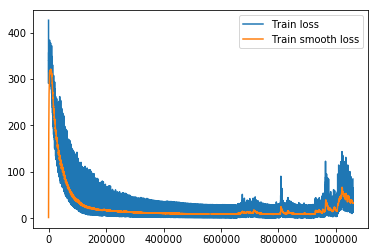

In [10]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 2 # depth
n_iter = 300 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = LSTM(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()